In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm

import numpy as np
import pandas as pd
import re, os, sys

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['pdf.fonttype'] = 42

import math

font_name = {'fontname':'Arial'}

plt.rcParams["font.family"] = "Arial"


In [2]:
# parameter settings

GPNotebook_dir = r"/Users/yingweihu/Documents/GitHub/GPNotebook"
data_name = "PDAC"

# working directory, wd
wd = os.path.join(GPNotebook_dir,"sample",data_name)
# input meta path: standardrized meta table
meta_path = os.path.join(wd,"meta/info.tsv")
# input expression matrix path
data_dir = os.path.join(wd,"data")

result_dir = os.path.join(wd,"result")

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
tool_dir = os.path.join(result_dir,"GPNotebook")
if not os.path.exists(tool_dir):
    os.mkdir(tool_dir)
    
job_dir = os.path.join(tool_dir,"survival_analysis")
if not os.path.exists(job_dir):
    os.mkdir(job_dir)
    
out_fig_KMC_path = os.path.join(job_dir, "kaplan_meier_curve.svg")
out_data_KMC_path = os.path.join(job_dir, "kaplan_meier_data.tsv")

# print file location and verify the file path
print("Parameters")
print(f'--meta {meta_path}',
     os.path.exists(meta_path))
print(f'--output_idr {job_dir}',
     os.path.exists(job_dir))
print(f'--out_fig_KMC {out_fig_KMC_path}')
print(f'--out_data_KMC {out_data_KMC_path}')


# column name in meta table for event, 1 for dead, 0 for alive
e = 'VitalStatus'
# nan value: unknown
nan_value = 'Unknown'
# label for living
l = 'Living'
# label for death
d = 'Deceased'
# column name in meta table for survival days
days = 'SurvivalDays'

Parameters
--meta /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/meta/info.tsv True
--output_idr /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis True
--out_fig_KMC /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis/kaplan_meier_curve.svg
--out_data_KMC /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis/kaplan_meier_data.tsv


In [3]:
# load meta data
meta_df = pd.read_csv(meta_path,sep="\t")
meta_df.head(10)

,Sample,CaseID,VitalStatus,SurvivalDays,Age,Gender,DeathCause
0,C3L-00102.N,C3L-00102,Deceased,249.0,42,Male,pancreatic carcinoma
1,C3L-00189.N,C3L-00189,Deceased,1035.0,68,Female,pancreatic carcinoma
2,C3L-00277.N,C3L-00277,Deceased,610.0,69,Male,pancreatic carcinoma
3,C3L-00401.N,C3L-00401,Living,1228.0,62,Female,Unknown
4,C3L-00640.N,C3L-00640,Living,594.0,59,Female,Unknown
5,C3L-00819.N,C3L-00819,Deceased,602.0,74,Male,pancreatic carcinoma
6,C3L-00881.N,C3L-00881,Living,3.0,80,Male,Unknown
7,C3L-00928.N,C3L-00928,Deceased,761.0,58,Female,pancreatic carcinoma
8,C3L-01031.N,C3L-01031,Living,369.0,64,Female,Unknown
9,C3L-01036.N,C3L-01036,Living,765.0,64,Male,Unknown


In [4]:
# clean data for records with nan value of vital status and survival days
meta_df2 = meta_df[meta_df[e]!=nan_value]
meta_df2 = meta_df2[pd.notna(meta_df[days])]
meta_df2[e] =  meta_df2[e].map(lambda x: True if x == d else False)

<ipython-input-4-be06898b98e1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta_df2 = meta_df2[pd.notna(meta_df[days])]


In [5]:
meta_df2

,Sample,CaseID,VitalStatus,SurvivalDays,Age,Gender,DeathCause
0,C3L-00102.N,C3L-00102,True,249.0,42,Male,pancreatic carcinoma
1,C3L-00189.N,C3L-00189,True,1035.0,68,Female,pancreatic carcinoma
2,C3L-00277.N,C3L-00277,True,610.0,69,Male,pancreatic carcinoma
3,C3L-00401.N,C3L-00401,False,1228.0,62,Female,Unknown
4,C3L-00640.N,C3L-00640,False,594.0,59,Female,Unknown
...,...,...,...,...,...,...,...
194,C3N-03754.T,C3N-03754,False,483.0,44,Male,Unknown
195,C3N-03853.T,C3N-03853,False,259.0,49,Female,Unknown
196,C3N-04126.T,C3N-04126,True,348.0,42,Male,pancreatic carcinoma
197,C3N-04283.T,C3N-04283,True,1.0,66,Female,complication due to medical/surgical care


In [6]:
# use data as the input value for plots
data = meta_df2

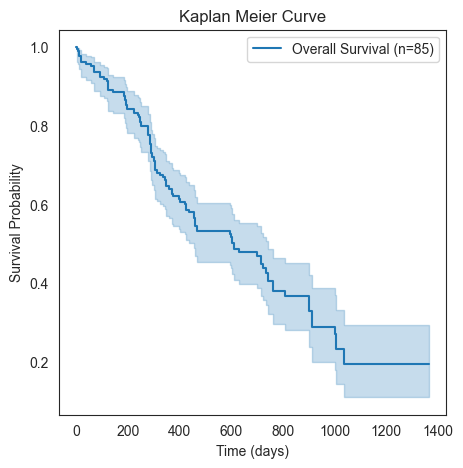

In [7]:
# plot K-M curve using lifelines

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

# Create Kaplan-Meier estimator objects for each group
kmf1 = KaplanMeierFitter()
kmf1.fit(data[days], event_observed=data[e])

fig,ax = plt.subplots(figsize=(5,5))
sns.set_style('white')
kmf1.plot(label='Overall Survival (n=85)')

plt.title('Kaplan Meier Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()

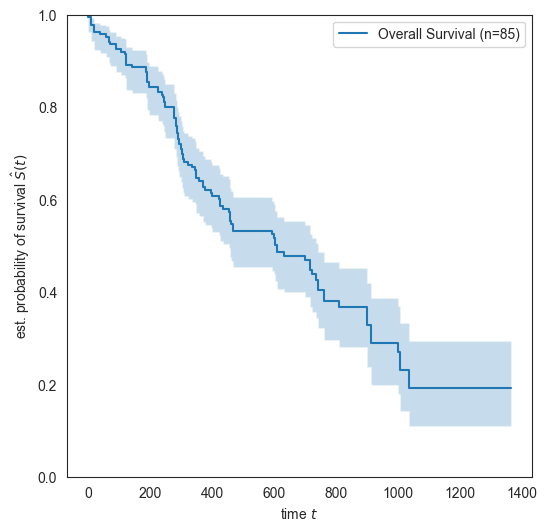

In [8]:
# plot K-M curve using scikit-survival
from sksurv.nonparametric import kaplan_meier_estimator

# Set the figure size
plt.figure(figsize=(6, 6))  # Example size: 10 inches by 6 inches


time, survival_prob, conf_int = kaplan_meier_estimator(
    data[e], data[days], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label='Overall Survival (n=85)')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend()

plt.savefig(out_fig_KMC_path,bbox_inches='tight')

In [9]:
# Create a DataFrame of survival data
conf_int_lower,conf_int_upper = conf_int
result = pd.DataFrame({
    'Time': time,
    'Survival Probability': survival_prob,
    'Confidence Interval Lower': conf_int_lower,
    'Confidence Interval Upper': conf_int_upper
})

# Save the DataFrame to a CSV file
result.to_csv(out_data_KMC_path,sep="\t", index=False)

In [10]:
result

,Time,Survival Probability,Confidence Interval Lower,Confidence Interval Upper
0,0.0,1.000000,1.000000,1.000000
1,1.0,0.994709,0.963039,0.999253
2,3.0,0.994709,0.963039,0.999253
3,8.0,0.989361,0.958133,0.997329
4,11.0,0.978665,0.944157,0.991939
...,...,...,...,...
114,1068.0,0.192867,0.109500,0.293889
115,1098.0,0.192867,0.109500,0.293889
116,1189.0,0.192867,0.109500,0.293889
117,1228.0,0.192867,0.109500,0.293889
